

# Object detection from Images
_** Object Detection - Sagemaker In built Algorithm **_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data Preparation](#Data_Preparation)
1. [Launch SAM/CloudFormation stack](#SAM/CloudFormation)
1. [Create Private WorkForce and run the Step Function workflow](#WorkFlow)

## Background

This notebook can be used to build an active learning workflow for object detection(bounding box) in images with amazon SageMaker in-built object-detection algorithm.

In the active learning workflow, some fraction of data(20%) is to be labeled by humans using SageMaker Ground Truth. With this labeled data, model is trained,  which is then, in turn used to label remaining part of dataset.

To demonstrate active learning workflow for object detection in images, we have used Caltech-UCSD Birds 200 dataset which can be downloaded from the link -> http://www.vision.caltech.edu/visipedia/CUB-200.html. We will be performing the bounding box task on the bird present in these images

In this Notebook we will  launch the SAM/cloudformation stack required to setup the step-function workflow for active learning and also prepare the dataset to be labeled.

## Setup

_This notebook was created and tested on an ml.m4.4xlarge notebook instance in the <b>us-east-1</b> region._

Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance. 


2. Ensure that CORS is enabled on the s3 bucket. Else Private worker won't be able to perform the labeling job assigned. You can enable CORS in the s3 bucket by following the link -> https://docs.aws.amazon.com/AmazonS3/latest/userguide/enabling-cors-examples.html


3. Ensure that the IAM role attached to the notebook instance you are using have the following AWS managed policies attached::- 
    - AWSCloudFormationFullAccess
    - AWSLambda_FullAccess
    - AWSStepFunctionsFullAccess
    - IAMFullAccess
    - AmazonSageMakerFullAccess
    - CloudWatchFullAccess
    - AmazonS3FullAccess

-- Importing the necessary libraries

In [1]:
%%time
import sagemaker
import boto3
import json
import os
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
from collections import defaultdict

role = get_execution_role()

sess = sagemaker.Session()

region = sess.boto_session.region_name
bucket= '<<Your-bucket-name>>'
key='sagemaker-model'



CPU times: user 764 ms, sys: 144 ms, total: 907 ms
Wall time: 836 ms


In [2]:
EXP_NAME = 'active-learning-demo'
RUN_FULL_AL_DEMO = True

## Data_Preparation

In this stage, we will create the augment manifest file from the images for which we have to perform object detection task.

We are uploading the images and the augment manifest file to the s3 bucket.

In [3]:
import boto3
s3 = boto3.resource('s3')

image_files = os.listdir("./images")

image_s3_key = "images"

manifest_file = 'input.manifest'
with open(manifest_file, 'w') as outfile:
    for file in image_files:
        if file.endswith('.jpg'):
            local_path = './images/{}'.format(file)
            s3Path = '{}/{}'.format(image_s3_key,file)
            try:
                s3.Bucket(bucket).upload_file(local_path, s3Path)
                s3FullPath = "s3://{}/{}".format(bucket,s3Path)
                outfile.write('{"source-ref": "' + s3FullPath +'"}\n') 
            except:
                print('File ->{} not uploaded'.format(local_path))
                continue
boto3.resource('s3').Bucket(bucket).upload_file(manifest_file,key+ "/" + manifest_file)
manifest_file_uri =  "s3://{}/{}".format(bucket,key+ "/" + manifest_file)

## SAM/CloudFormation

To launch all the AWS resources required for creation of the object detection bounding box active learning workflow, we use a CloudFormation/SAM Stack

### Pre-req to build:

1. Install [AWS SAM CLI](https://docs.aws.amazon.com/serverless-application-model/latest/developerguide/serverless-sam-cli-install.html)
2. Install [Python 3.7](https://www.python.org/downloads/)


### How to build:

1. go to folder `<github-root-dir>/active-learning-object-detection/src`
2. To build the code in this repository run: ` sam build `
    
### Pre-req to deploy:

1. Export the temporary AWS security token. Follow the instructions listed <a href = "https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_temp_use-resources.html#using-temp-creds-sdk-cli">here</a>
2. Create the S3 bucket which will be used when deploying the model.

### How to deploy:
To create AWS resources required for creation of an active learning workflow, we use a [CloudFormation Stack](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/stacks.html). 

Run command: `sam deploy -t <template_path> --region <region> --stack-name <stack_name> --s3-bucket <your_bucket_name> --capabilities <capabilities>` where options are as follows
  * `--region` specifies the AWS Region where you would like to launch this Stack.
  * `--stack-name` name of the CloudFormation stack. 
  * `--s3-bucket` name of S3 bucket in the region specified by `--region` parameter value.
  * `--capabilities` capabilities used in stack

For example:
`sam deploy -t .aws-sam/build/template.yaml --region us-west-2 --stack-name example-stack-name --s3-bucket your-bucket-name-us-west-2 --capabilities CAPABILITY_IAM CAPABILITY_AUTO_EXPAND`

Following the above steps, we have deployed the cloud-formation stack in the below cells.

In [4]:
cd src

/home/ec2-user/SageMaker/RBL/GroundTruth/src


In [5]:
!sam build

Building codeuri: /home/ec2-user/SageMaker/RBL/GroundTruth/src runtime: python3.7 metadata: {} functions: ['PerformActiveLearning', 'PrepareForTraining', 'CopyInputManfiest', 'CreateValidationSet', 'AddRecordId', 'UpdateMetaData', 'ExportPartialOutput', 'GetCounts', 'PrepareForHumanLabeling', 'PrepareForInference', 'CheckModelEvaluation', 'GetModelEvaluation', 'CopyImage', 'PerformFinalExport']

Build Failed
Error: PythonPipBuilder:Validation - Binary validation failed for python, searched for python in following locations  : ['/home/ec2-user/anaconda3/envs/python3/bin/python', '/usr/bin/python'] which did not satisfy constraints for runtime: python3.7. Do you have python for runtime: python3.7 on your PATH?


In [6]:
stack_name = "cloud-check"
!sam deploy --region $region --stack-name $stack_name --s3-bucket $bucket --capabilities CAPABILITY_IAM CAPABILITY_AUTO_EXPAND

Uploading to f78c1ec7d5369a96b25253d4db708eeb  516092 / 516092  (100.00%)

	Deploying with following values
	Stack name                   : cloud-check
	Region                       : us-east-1
	Confirm changeset            : False
	Deployment s3 bucket         : gt-object-detection
	Capabilities                 : ["CAPABILITY_IAM", "CAPABILITY_AUTO_EXPAND"]
	Parameter overrides          : {}
	Signing Profiles             : {}

Initiating deployment
Uploading to 39d0d11c9d8685845b186d7127840994.template  32289 / 32289  (100.00%)

Waiting for changeset to be created..

CloudFormation stack changeset
-------------------------------------------------------------------------------------------------
Operation                LogicalResourceId        ResourceType             Replacement            
-------------------------------------------------------------------------------------------------
+ Add                    ActiveLearningLoop       AWS::StepFunctions::St   N/A                    


CREATE_IN_PROGRESS       AWS::Lambda::Function    PerformFinalExport       Resource creation      
                                                                           Initiated              
CREATE_COMPLETE          AWS::Lambda::Function    GetModelEvaluation       -                      
CREATE_COMPLETE          AWS::Lambda::Function    GetCounts                -                      
CREATE_COMPLETE          AWS::Lambda::Function    CopyInputManfiest        -                      
CREATE_COMPLETE          AWS::Lambda::Function    AddRecordId              -                      
CREATE_COMPLETE          AWS::Lambda::Function    ExportPartialOutput      -                      
CREATE_COMPLETE          AWS::Lambda::Function    PrepareForInference      -                      
CREATE_IN_PROGRESS       AWS::Lambda::Function    CheckModelEvaluation     Resource creation      
                                                                           Initiated              
CREATE_IN_

## WorkFlow

In this stage, will :-

- Create a UI template for the bounding box labeling job
- Create Private Worker
- Launch the Step-Function workflow
- Check for final_output.manifest file in S3 bucket after labelling finished
- Visualize the output manifest file

https://docs.aws.amazon.com/sagemaker/latest/dg/sms-bounding-box.html

In [7]:
s3_client = boto3.client('s3')

This cell will specify the labels that workers will use to categorize the images. Since our task it performing bounding box in the bird present in images, we are providing a single label as 'Bird'. To customize your labeling job, add your own labels here. To learn more, see <a href = "https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateLabelingJob.html#sagemaker-CreateLabelingJob-request-LabelCategoryConfigS3Uri">LabelCategoryConfigS3Uri</a>.

In [8]:
label_file_name = "class_labels.json"
label_file = """{
    "documentVersion": "2020-03-01",
    "labels": [
        {
            "label": "Bird"
        }
    ]
}"""

s3_client.put_object(Body=label_file, Bucket=bucket, Key=key+ "/" + label_file_name)
label_file_uri =  "s3://{}/{}".format(bucket,key+ "/" + label_file_name)

The following cell will specify our custom worker task template. This template will configure the UI that workers will see when they open our bounding box labeling job tasks. To learn how to customize this cell, see <a href = "https://docs.aws.amazon.com/sagemaker/latest/dg/sms-custom-templates-step2.html"> Creating your custom labeling task template.</a>

In [9]:
template_file_name = "instructions.template"
template_file = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
  <crowd-bounding-box
    name="boundingBox"
    src="{{ task.input.taskObject | grant_read_access }}"
    header="{{ task.input.header }}"
    labels="{{ task.input.labels | to_json | escape }}"
  >

    <!-- The <full-instructions> tag is where you will define the full instructions of your task. -->
    <full-instructions header="Bounding Box Instructions" >
      <p>Use the bounding box tool to draw boxes around the requested target of interest:</p>
      <ol>
        <li>Draw a rectangle using your mouse over each instance of the target.</li>
        <li>Make sure the box does not cut into the target, leave a 2 - 3 pixel margin</li>
        <li>
          When targets are overlapping, draw a box around each object,
          include all contiguous parts of the target in the box.
          Do not include parts that are completely overlapped by another object.
        </li>
        <li>
          Do not include parts of the target that cannot be seen,
          even though you think you can interpolate the whole shape of the target.
        </li>
        <li>Avoid shadows, they're not considered as a part of the target.</li>
        <li>If the target goes off the screen, label up to the edge of the image.</li>
      </ol>
    </full-instructions>

    <!-- The <short-instructions> tag allows you to specify instructions that are displayed in the left hand side of the task interface.
    It is a best practice to provide good and bad examples in this section for quick reference. -->
    <short-instructions>
      Use the bounding box tool to draw boxes around the requested target of interest.
    </short-instructions>
  </crowd-bounding-box>
</crowd-form>
"""


s3_client.put_object(Body=template_file, Bucket=bucket, Key=key+ "/" + template_file_name)
template_file_uri =  "s3://{}/{}".format(bucket,key+ "/" + template_file_name)

We are using a private work team to labeling your data objects, so you need to create a private work force and input your work team ARN for private_workteam_arn. You must have a private workforce in the same AWS Region as your labeling job task request to use a private work team. To learn more see <a href = "https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-private.html"> Use a Private Workforce</a>

In [10]:
private_workteam_arn = 'SET YOUR PRIVATE WORKTEAM ARN'

This cell will automatically configure a pre- and post-annotation ARNs (prehuman_arn and acs_arn respectively).


To customize your labeling job task type, you will need to modify prehuman_arn and acs_arn.


If you are using one of the Ground Truth built-in task types, you can find pre- and post-annotation lambda ARNs using the following links.

<ul>
    <li>Pre-annotation lambda ARNs for built in task types can be found in <a href = "https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_HumanTaskConfig.html#API_HumanTaskConfig_Contents">HumanTaskConfig.</a></li>
    <li>Post-annotation lambda ARNs (Annotation Consolidation Lambda) for built in task types can be found in <a href = "https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_AnnotationConsolidationConfig.html#sagemaker-Type-AnnotationConsolidationConfig-AnnotationConsolidationLambdaArn">AnnotationConsolidationConfig.</a></li>

In [11]:
# Specify ARNs for resources needed to run a bounding box job.
ac_arn_map = {'us-west-2': '081040173940',
              'us-east-1': '432418664414',
              'us-east-2': '266458841044',
              'eu-west-1': '568282634449',
              'ap-northeast-1': '477331159723',
             'ap-south-1':'565803892007'}


prehuman_arn = 'arn:aws:lambda:{}:{}:function:PRE-BoundingBox'.format(region, ac_arn_map[region])
acs_arn = 'arn:aws:lambda:{}:{}:function:ACS-BoundingBox'.format(region, ac_arn_map[region])

The following cell specifies our labeling job name, the description workers see, and tags that workers can use to find our labeling job task.

In [12]:
job_name_prefix = "bird-detection"
task_description = 'Draw a tight Cuboid'
task_keywords = ['Bird', 'Cuboid']
task_title = task_description

The following cells uploads the post processing_file in the s3 bucket

In [13]:
cd ..

/home/ec2-user/SageMaker/RBL/GroundTruth


In [14]:
POSTPROCESSING_SCRIPT_LOCATION = "./post_processing.py"
s3_prefix = 'processing_job'
input_code = sess.upload_data(
    POSTPROCESSING_SCRIPT_LOCATION,
    bucket= bucket,
    key_prefix=s3_prefix,
)
PostProcessingJobUri = 's3://{}/{}/post_processing.py'.format(bucket,s3_prefix)

Modify the following request to customize your labeling job request. For more information on the parameters below, see <a href = "https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateLabelingJob.html">CreateLabelingJob.</a>

In [15]:
human_task_config = {
      "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
      },
      "PreHumanTaskLambdaArn": prehuman_arn,
      "MaxConcurrentTaskCount": 200, # 200 texts will be sent at a time to the workteam.
      "NumberOfHumanWorkersPerDataObject": 1, # 1 workers will be enough to label each text.
      "TaskAvailabilityLifetimeInSeconds": 21600, # Your work team has 6 hours to complete all pending tasks.
      "TaskDescription": task_description,
      "TaskKeywords": task_keywords,
      "TaskTimeLimitInSeconds": 300, # Each text must be labeled within 5 minutes.
      "TaskTitle": task_title,
      "UiConfig": {
        "UiTemplateS3Uri": template_file_uri,
      }
    }


human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
        "InputConfig" : {
          "DataSource": {
            "S3DataSource": {
              "ManifestS3Uri": manifest_file_uri,
            }
          },
          "DataAttributes": {
            "ContentClassifiers": [
              "FreeOfPersonallyIdentifiableInformation",
              "FreeOfAdultContent"
            ]
          },  
        },
        "OutputConfig" : {
          "S3OutputPath": 's3://{}/{}/output/'.format(bucket, key),
        },
        "S3TempPath": 's3://{}/{}/temp/'.format(bucket, key),
        "HumanTaskConfig" : human_task_config,
        "LabelingJobNamePrefix": job_name_prefix,
        "RoleArn": role, 
        "LabelAttributeName": "bird-labelling-job-clone", # Edit it according to the your manifest
        "LabelCategoryConfigS3Uri": label_file_uri,
        "Region":region,
    "PostProcessingJobUri":PostProcessingJobUri,
    }
    


In [16]:
print(json.dumps(ground_truth_request, indent=2))

{
  "InputConfig": {
    "DataSource": {
      "S3DataSource": {
        "ManifestS3Uri": "s3://gt-object-detection/sagemaker-model/input.manifest"
      }
    },
    "DataAttributes": {
      "ContentClassifiers": [
        "FreeOfPersonallyIdentifiableInformation",
        "FreeOfAdultContent"
      ]
    }
  },
  "OutputConfig": {
    "S3OutputPath": "s3://gt-object-detection/sagemaker-model/output/"
  },
  "S3TempPath": "s3://gt-object-detection/sagemaker-model/temp/",
  "HumanTaskConfig": {
    "AnnotationConsolidationConfig": {
      "AnnotationConsolidationLambdaArn": "arn:aws:lambda:us-east-1:432418664414:function:ACS-BoundingBox"
    },
    "PreHumanTaskLambdaArn": "arn:aws:lambda:us-east-1:432418664414:function:PRE-BoundingBox",
    "MaxConcurrentTaskCount": 200,
    "NumberOfHumanWorkersPerDataObject": 1,
    "TaskAvailabilityLifetimeInSeconds": 21600,
    "TaskDescription": "Draw a tight Cuboid",
    "TaskKeywords": [
      "Bird",
      "Cuboid"
    ],
    "TaskTimeLimitIn

# Do the following steps to trigger the Active Learning loop.

<ol>
    <li>Open the AWS Step Functions console: <a href = "http://console.aws.amazon.com/states">http://console.aws.amazon.com/states</a></li>
    <li>The Cloud Formation stack has generated two step function in the State Machines section: <b>ActiveLearningLoop-*</b> and <b>ActiveLearning-*</b> where * will be replaced with the name you used when you launched your Cloud Formation stack.</li>
    <li>Select <b>ActiveLearningLoop-*. </b></li>
    <li>Choose <b>Start Execution.</b></li>
    <li>Paste the JSON above in <b>Input – optional code-block.</b></li>
    <li>Select <b>Start execution.</b></li>
</ol>       

## Caution :---
#### If you are building the workflow in the region other than us-east-1, then do the following changes:-
<ol>
    <li>On the AWS Lambda console, locate the Lambda function with the name <b>*-PrepareForTraining-<###></b> where * is the name you used when you launched your CloudFormation stack and -<###> is a list of letters and numbers.</li>
    <li>Identify the existing algorithm specification, which looks like the following code:</li>
        <img src = "docker.png"></img>
    <li>Change the value of  <b>TrainingImage</b> key to training image uri of the sagemaker object detection model of your region. Check the following link to get the  training image uri:- <a href="https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html ">Sagemaker-algo-docker-registry </a>. After edit, save the lamda function and click on <b>deploy</b> button. </li>
    <li>On the AWS Step Functions console, choose State Machines.</li>
    <li>Select the radio button near <b>ActiveLearning-*</b></li> 
    <li>Choose <b> Edit.</b></li>
    <li>Look for the <b>Inference post-processing step</b>  state, this step is responsible for invoking the sagemaker processing job which performs necessary post-processing in the output generated by the object detection model.</li>
    <li> In this step, look for <b>AppSpecification</b>, which looks like the following code:</li>
    <img src = "post_processing.png"></img>
    <li>Here change the value of <b>ImageUri</b> key according to the pre-built sklearn container image uri of your region. Check the following link to get the  container image uri:- <a href="https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-docker-containers-scikit-learn-spark.html ">Sagemaker Pre-built Sklearn container<a/> </li>
    
</ol>    
       
These manual steps could be automated by using the data science SDK. Please refer to the details
<a href="https://aws.amazon.com/about-aws/whats-new/2019/11/introducing-aws-step-functions-data-science-sdk-amazon-sagemaker/">here</a> for more information.



On successful completion of the active learning loop, the state machine will output the final output manifest file and the latest trained model output.



###  Reading the manifest file after the labelling job completed

In [17]:
file_name = 'final_output.manifest'
OutputPath = "s3://{}/{}/output/{}".format(bucket, key,file_name)

!aws s3 cp $OutputPath ./ --quiet

In [18]:
def read_manifest_file(file_path):
    with open(file_path, 'r') as f:
        output = [json.loads(line.strip()) for line in f.readlines()]
        return output

In [19]:
output = read_manifest_file(file_name)

### Visualize the Ouput Manifest file

In [20]:
def visualize_detection(img_file, annotations, class_name, thresh=0.6):
    """
    visualize detections in one image
    Parameters:
    ----------
    img : numpy.array
        image, in bgr format
    dets : numpy.array
        ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
        each row is one object
    classes : tuple or list of str
        class names
    thresh : float
        score threshold
    """
    import random
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    img = mpimg.imread(img_file)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    num_detections = 0
    annotations = annotations[0]
    print(annotations)
    print(annotations['left'])
    xmin = int(annotations['left'])
    ymin = int(annotations['top'])
    height = int(annotations['height'])
    width = int(annotations['width'])
    
    cls_id = annotations['class_id']

    if cls_id not in colors:
        colors[cls_id] = (random.random(), random.random(), random.random())

    rect = plt.Rectangle(
        (xmin, ymin),
        width,
        height,
        fill=False,
        edgecolor=colors[cls_id],
        linewidth=3.5,
    )
    plt.gca().add_patch(rect)

    print("{}".format(class_name))
    plt.gca().text(
        xmin,
        ymin - 2,
        "{:s}".format(class_name),
        bbox=dict(facecolor=colors[cls_id], alpha=0.5),
        fontsize=12,
        color="white",
    )

    plt.show()

In [21]:
def show_bird_prediction(filename, annotations,OBJECT_CATEGORIES, thresh=0.40):
    visualize_detection(filename, annotations, OBJECT_CATEGORIES, thresh)

In the below cell, we are visualizing the ouput for top 5 images in the final_output.manifest file

{'class_id': 0, 'top': 261, 'left': 262, 'height': 188, 'width': 316}
262
Bird


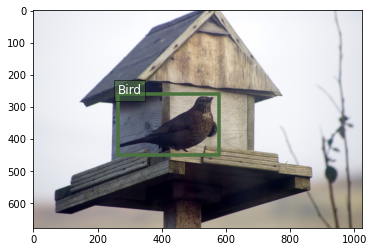

{'class_id': 0, 'top': 77, 'left': 200, 'height': 932, 'width': 568}
200
Bird


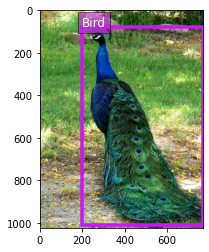

{'class_id': 0, 'top': 272, 'left': 135, 'height': 306, 'width': 694}
135
Bird


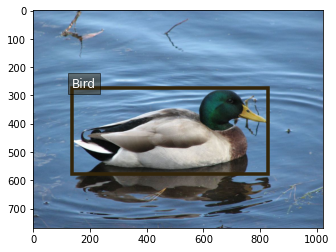

{'class_id': 0, 'top': 96, 'left': 112, 'height': 928, 'width': 614}
112
Bird


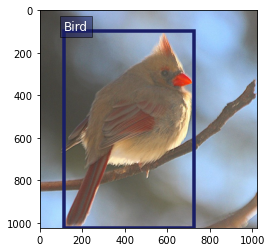

{'class_id': 0, 'top': 88, 'left': 49, 'height': 529, 'width': 793}
49
Bird


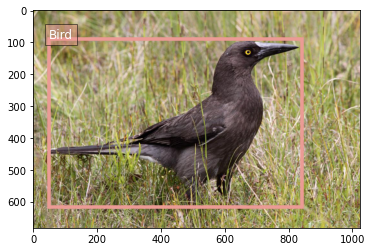

In [22]:
for element in output[:5]:
    pics3Path = element['source-ref']
    ! aws s3 cp $pics3Path ./output_image --quiet   
    show_bird_prediction('output_image',element['bird-labelling-job-clone']['annotations'],
                         element['bird-labelling-job-clone-metadata']['class-map']['0'])